In [1]:
import pywt
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
from time import clock


def dwt(N):
    g, h = pywt.Wavelet('sym8').filter_bank[:2]
    L = len(h)  # Length of bandwidth
    rank_max = int(np.log2(N))  # Maximum Layer
    rank_min = int(np.log2(L))+1  # Minimum Layes
    ww = np.eye(2**rank_max)  # Proprocessing Matrix

    for jj in range(rank_min, rank_max+1):
        nn = 2**jj
        # Construct vector
        p1_0 = np.concatenate([g, np.zeros(nn-L)])
        p2_0 = np.concatenate([h, np.zeros(nn-L)])
        p1 = []
        p2 = []
        # Circular move
        for ii in range(2**(jj-1)):
            shift = 2*ii
            p1.append(np.roll(p1_0, shift))
            p2.append(np.roll(p2_0, shift))
        p1 = np.stack(p1)
        p2 = np.stack(p2)
        # Orthogonal Matrix
        w1 = np.concatenate([p1, p2])
        wL = len(w1)
        w = np.eye(2**rank_max)
        w[:wL, :wL] = w1
        ww = ww@w
    return ww



def omp(s, T, N):
    T2 = T.copy()
    sz = T.shape  # Size of measurement Matrix
    M = sz[0]  # Measure
    hat_y = np.zeros(N)  # coefficients to be recovered
    selected_rows = []
    r_n = s  # error

    for times in range(M):  # Iteration number
        product = np.abs(T2.T@r_n)
        pos = np.argmax(product)
        selected_rows.append(pos)  # Find residual largest point
        Aug_t = T[:, selected_rows].reshape(M, -1)
        T2[:, pos] = 0  # zero out picked column
        aug_y = np.linalg.lstsq(Aug_t, s)[0]  # Least squares
        r_n = s-Aug_t@aug_y  # Residual
        if (abs(aug_y[-1])**2)/(aug_y@aug_y)**0.5 < 0.05:  # Find best error cut off
            break

    hat_y[selected_rows] = aug_y
    return hat_y




/home/jfftilton/anaconda3/envs/omsa/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


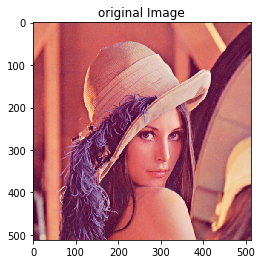

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


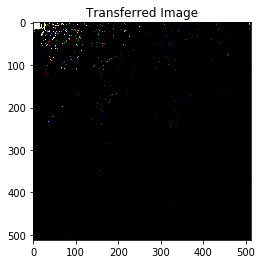

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


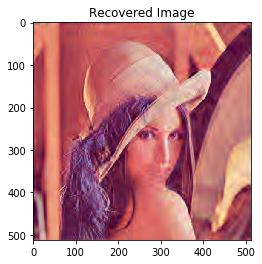

In [3]:
X = plt.imread('Lenna.png')*1.
a, b, c = X.shape
M = np.int(np.floor(a*.7))
R = np.random.normal(size=(M, a))
Y0 = R@X[:,:,0]
Y1 = R@X[:,:,1]
Y2 = R@X[:,:,2]
N = a


ww = dwt(N)


Y0 = Y0@ww.T
Y1 = Y1@ww.T
Y2 = Y2@ww.T

R = R@ww.T



X2 = np.zeros(X.shape)  # Recover matrix
for idx,Y in enumerate([Y0,Y1,Y2]):
    for i in range(b):  # by column
        rec = omp(Y[:, i], R, a)
        X2[:, i, idx] = rec
        
# original Image
plt.figure()
plt.imshow(X)
plt.title('original Image')
plt.show()

# Transfered Image
plt.figure()
plt.imshow(np.clip(X2, 0, 255))
plt.title('Transferred Image')
plt.show()


# Recovered image
X3 = np.zeros(X.shape)
plt.figure()
for i in range(c):
    X3[:,:,i] = ww.T@X2[:,:,i]@ww  # inverse DWT

plt.imshow(np.clip(X3, 0, 255))
plt.title('Recovered Image')
plt.show()

In [5]:
mse = np.mean((X - np.clip(X3, 0, 255))**2)
mse

0.002144968320135735